Источник данных: https://data.world/data-society/bank-marketing-data

Это данные одного из банковских учреждений для проведения маркетинговых компаний.

Цель задачи - предсказать, подпишет ли клиент (да / нет) срочный депозит. Это столбец 'y'.



In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline


In [3]:
data = pd.read_csv('bank-additional-full.csv', sep = ';')
data


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [5]:
data.describe()


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# В 'duration', 'campaign' и 'previous' заметны выбросы

In [7]:
data.isnull().sum()


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [8]:
# Класс - данные без пропусков

## Целевая переменная

In [9]:
data['y'].value_counts()


no     36548
yes     4640
Name: y, dtype: int64

In [10]:
# Данные плохо сбалансированы

## job

In [11]:
data['job'].value_counts()


admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [12]:
pd.crosstab(data['y'], data['job'])


job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
y,,,,,,,,,,,,
no,9070,8616,1332,954,2596,1286,1272,3646,600,6013,870,293
yes,1352,638,124,106,328,434,149,323,275,730,144,37


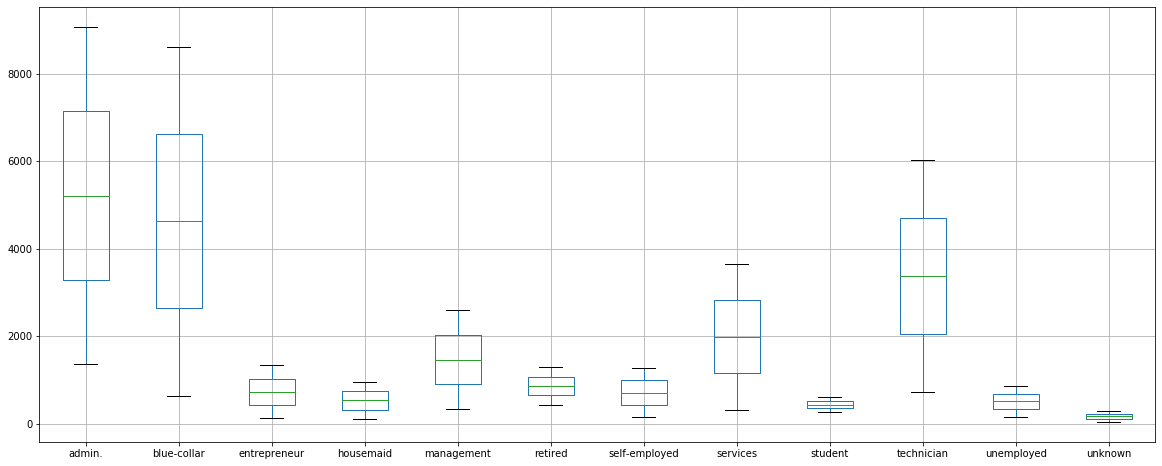

In [16]:
pd.crosstab(data['y'], data['job']).boxplot(return_type = 'axes', figsize = (20, 8));


## marital

In [17]:
data['marital'].value_counts()


married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [18]:
pd.crosstab(data['marital'], data['y'])


y,no,yes
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


# age

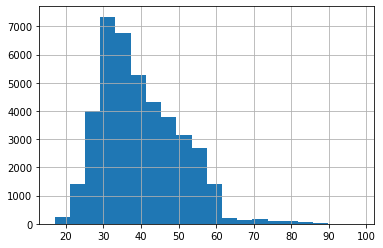

In [19]:
data['age'].hist(bins = 20);


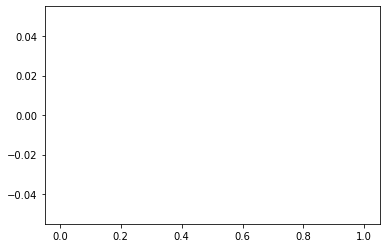

In [24]:
plt.hist(data[data['y'] == 1]['age'], bins = 20, alpha = 0.5)
plt.hist(data[data['y'] == 0]['age'], bins = 20, alpha = 0.5);
plt.show()


### education

In [25]:
data['education'].value_counts()


university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [26]:
pd.crosstab(data['education'], data['y'])


y,no,yes
education,,
basic.4y,3748,428
basic.6y,2104,188
basic.9y,5572,473
high.school,8484,1031
illiterate,14,4
professional.course,4648,595
university.degree,10498,1670
unknown,1480,251


## default

In [27]:
data['default'].value_counts()


no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [28]:
pd.crosstab(data['default'], data['y'])


y,no,yes
default,,
no,28391,4197
unknown,8154,443
yes,3,0


## housing

In [29]:
data['housing'].value_counts()


yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [30]:
pd.crosstab(data['housing'], data['y'])


y,no,yes
housing,,
no,16596,2026
unknown,883,107
yes,19069,2507


## loan

In [31]:
data['loan'].value_counts()


no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [32]:
pd.crosstab(data['loan'], data['y'])


y,no,yes
loan,,
no,30100,3850
unknown,883,107
yes,5565,683


### contact

In [33]:
data['contact'].value_counts()


cellular     26144
telephone    15044
Name: contact, dtype: int64

In [34]:
pd.crosstab(data['y'], data['contact'])


contact,cellular,telephone
y,,
no,22291,14257
yes,3853,787


### month

In [35]:
data['month'].value_counts()


may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

In [36]:
pd.crosstab(data['month'], data['y'])


y,no,yes
month,,
apr,2093,539
aug,5523,655
dec,93,89
jul,6525,649
jun,4759,559
mar,270,276
may,12883,886
nov,3685,416
oct,403,315


### day_of_week

In [37]:
data['day_of_week'].value_counts()


thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

In [38]:
pd.crosstab(data['day_of_week'], data['y'])


y,no,yes
day_of_week,,
fri,6981,846
mon,7667,847
thu,7578,1045
tue,7137,953
wed,7185,949


### poutcome

In [39]:
data['poutcome'].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [40]:
pd.crosstab(data['poutcome'], data['y'])


y,no,yes
poutcome,,
failure,3647,605
nonexistent,32422,3141
success,479,894


In [41]:
# Если предыдущая маркетинговая кампания завершилась успехом, то среди таких клиентов преобладает положительный ответ.

## duration

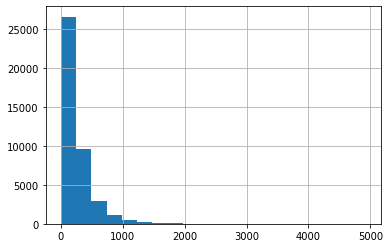

In [42]:
data['duration'].hist(bins = 20);


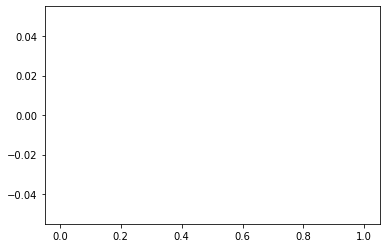

In [43]:
plt.hist(data[data['y'] == 1]['duration'], bins = 20, alpha = 0.5, label = 'yes')
plt.hist(data[data['y'] == 0]['duration'], bins = 20, alpha = 0.5, label = 'no');


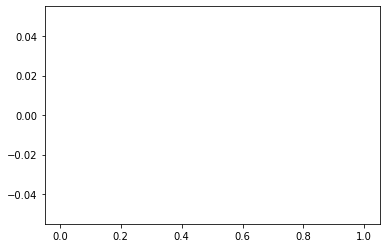

In [46]:
plt.hist(data[data['y'] == 1]['duration']);


## campaign

In [47]:
data['campaign'].value_counts()


1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

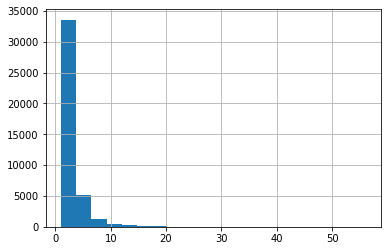

In [48]:
data['campaign'].hist(bins = 20);


In [49]:
pd.crosstab(data['y'], data['campaign'])


campaign,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,39,40,41,42,43,56
y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
no,15342,9359,4767,2402,1479,904,591,383,266,213,165,122,88,68,49,51,54,33,26,30,24,17,15,15,8,8,11,8,10,7,7,4,4,3,5,1,1,2,1,2,2,1
yes,2300,1211,574,249,120,75,38,17,17,12,12,3,4,1,2,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
# как видим, у клиентов с 15 и более проведенными маркетинговыми кампаниями практически одни отказы

## pdays

In [51]:
pd.crosstab(data['pdays'], data['y'])


y,no,yes
pdays,,
0,5,10
1,18,8
2,24,37
3,141,298
4,55,63
5,17,29
6,123,289
7,20,40
8,6,12


## previous


In [52]:
data['previous'].value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

In [53]:
pd.crosstab(data['previous'], data['y'])


y,no,yes
previous,,
0,32422,3141
1,3594,967
2,404,350
3,88,128
4,32,38
5,5,13
6,2,3
7,1,0


## emp.var.rate

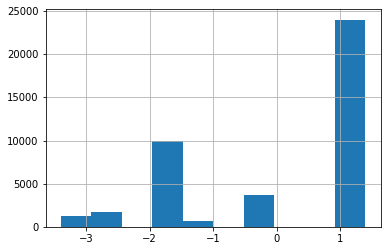

In [54]:
data['emp.var.rate'].hist(bins = 10);


In [55]:
data['emp.var.rate'].nunique()

10

## cons.price.idx

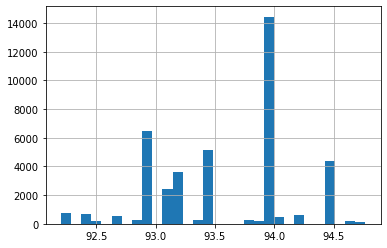

In [56]:
data['cons.price.idx'].hist(bins = 30);


In [57]:
data['cons.price.idx'].nunique()


26

## cons.conf.idx

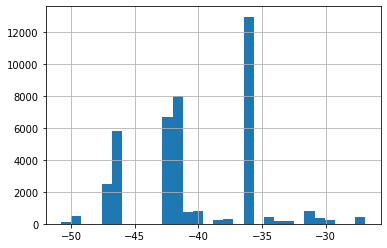

In [58]:
data['cons.conf.idx'].hist(bins = 30);


In [59]:
data['cons.conf.idx'].nunique()

26

## euribor3m	

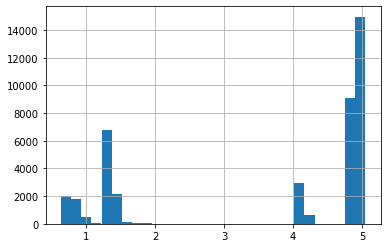

In [60]:
data['euribor3m'].hist(bins = 30);

In [61]:
data['euribor3m'].nunique()

316

## nr.employed

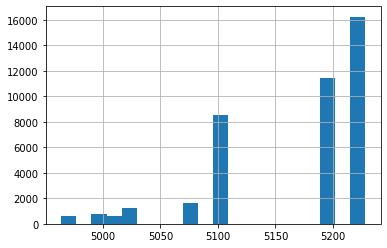

In [62]:
data['nr.employed'].hist(bins = 20);

In [63]:
data['nr.employed'].nunique()

11

In [64]:
Corr = data.corr()

CorField = []
CorPairs = []
CorrDel = []

for i in Corr:
    for j in Corr.index[Corr[i] > 0.8]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            CorPairs.append([i, j, Corr[i][Corr.index == j].values[0]])
            if i not in CorrDel:
                CorrDel.append(i)
            print (i, '-->', j, ': R =', Corr[i][Corr.index == j].values[0])

emp.var.rate --> euribor3m : R = 0.9722446711515584
emp.var.rate --> nr.employed : R = 0.9069701012559412


# Обработка данных

In [65]:
numbers_features = [i for i in data if (data[i].dtypes == 'float64') or (data[i].dtypes == 'int64')]
numbers_features


['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [66]:
m = {'yes': 1, 'no': 0}
data['y'] = data['y'].map(m)
data['y'].astype('int64')


0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

In [67]:
data['y'].value_counts()


0    36548
1     4640
Name: y, dtype: int64

In [68]:
# Удалим коррелирующий столбец:
data = data.drop('emp.var.rate', axis = 1)


In [69]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size = 0.3, random_state = 42)
print(df_train.shape, df_test.shape)


(28831, 20) (12357, 20)


In [70]:
X_train = df_train.drop('y', axis = 1)
y_train = df_train['y']

X_test = df_test.drop('y', axis = 1)
y_test = df_test['y']


In [71]:
class MyLabelEncoder:
    def __init__(self):
        pass

    def fit(self, data):
        list_index = data.value_counts().index.tolist()
        list_value = [i for i in range(len(list_index))]
        l_dict = dict(zip(list_index, list_value))
        self.l_dict = l_dict
        return self 

    def transform(self, data_t):
        l_dict = self.l_dict
        unique_values = data_t.value_counts().index.tolist()
        for j in unique_values:
            if j not in l_dict:
                l_dict[j] = -1
        data_t = data_t.map(l_dict)
        return data_t

    def fit_transform(self, data):
        return self.fit(data).transform(data)


In [72]:
objects_features = [i for i in data if data[i].dtypes == 'object']
objects_features


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [73]:
for i in objects_features:
    le = MyLabelEncoder()
    le.fit(X_train[i])
    X_train[i] = le.transform(X_train[i])
    X_test[i] = le.transform(X_test[i])


In [74]:
X_train


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
39075,29,0,0,0,0,1,0,0,9,1,77,3,999,1,1,92.713,-33.0,0.709,5023.5
34855,29,2,1,0,0,1,0,1,0,4,12,4,999,0,0,92.893,-46.2,1.250,5099.1
7107,45,1,0,5,1,0,0,1,0,0,277,2,999,0,0,93.994,-36.4,4.860,5191.0
31614,34,3,0,0,0,1,0,0,0,0,70,1,999,1,1,92.893,-46.2,1.327,5099.1
34878,32,0,1,1,0,1,0,0,0,4,1181,9,999,0,0,92.893,-46.2,1.250,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,58,5,0,3,1,1,0,1,0,3,427,2,999,0,0,93.994,-36.4,4.857,5191.0
11284,37,4,0,0,0,1,0,1,3,0,288,1,999,0,0,94.465,-41.8,4.961,5228.1
38158,35,0,0,1,0,0,0,0,6,0,194,1,4,1,2,92.431,-26.9,0.754,5017.5
860,40,4,0,0,0,0,0,1,0,2,295,2,999,0,0,93.994,-36.4,4.856,5191.0


In [75]:
X_test


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
32884,57,2,0,1,0,1,1,0,0,1,371,1,999,1,1,92.893,-46.2,1.299,5099.1
3169,55,11,0,6,1,0,0,1,0,0,285,2,999,0,0,93.994,-36.4,4.860,5191.0
32206,33,1,0,2,0,1,0,0,0,4,52,1,999,1,1,92.893,-46.2,1.313,5099.1
9403,36,0,0,1,0,1,0,1,3,4,355,4,999,0,0,94.465,-41.8,4.967,5228.1
14020,27,8,0,1,0,0,0,0,1,4,189,2,999,0,0,93.918,-42.7,4.963,5228.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15908,46,3,0,1,0,0,0,0,1,1,181,2,999,0,0,93.918,-42.7,4.960,5228.1
28222,38,3,2,1,1,0,0,0,5,3,620,1,2,1,2,93.075,-47.1,1.453,5099.1
14194,26,1,1,1,0,1,1,1,1,1,251,2,999,0,0,93.918,-42.7,4.962,5228.1
19764,51,2,2,3,0,1,1,0,2,4,50,3,999,0,0,93.444,-36.1,4.966,5228.1


# ML

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier


In [77]:
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score, \
precision_score, recall_score, f1_score

def quality_report(prediction, actual):
    acc = accuracy_score(prediction, actual) * 100
    precision = precision_score(prediction, actual) * 100
    recall = recall_score(prediction, actual) * 100
    f1 = f1_score(prediction, actual) * 100
    rocauc = roc_auc_score(prediction, actual) * 100
    
    quality_list = [acc, precision, recall, f1, rocauc]
    
    return quality_list


### GradientBoostingClassifier

In [78]:
%%time
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)


CPU times: user 3.77 s, sys: 61.8 ms, total: 3.83 s
Wall time: 3.27 s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [79]:
pred_gbc = gbc.predict(X_test)

df_list = quality_report(pred_gbc, np.array(y_test))

df_quality = pd.DataFrame([df_list], 
                          columns=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
                          index=["GradientBoostingClassifier"]
                         )
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288


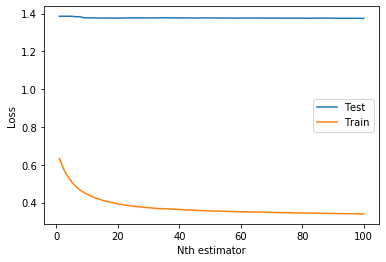

In [80]:
gb_staged_test_score = np.empty(len(gbc.estimators_))

for i, pred in enumerate(gbc.staged_predict(X_test)):
    gb_staged_test_score[i] = gbc.loss_(y_test, pred)

from tqdm import tqdm_notebook
plt.plot(np.arange(gbc.n_estimators) + 1, gb_staged_test_score, label='Test')
plt.plot(np.arange(gbc.n_estimators) + 1, gbc.train_score_, label='Train')
plt.xlabel("Nth estimator")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [81]:
params = {
    'n_estimators': range(1, 300),
    'max_depth': range(1, 30),
    'max_features': range(1, X_train.shape[1]),
    'learning_rate': [0.0003, 0.003, 0.03, 0.1, 0.5, 1],
    }


rand_cv = RandomizedSearchCV(gbc, param_distributions = params, 
                             n_iter = 20, random_state = 0, n_jobs = -1, verbose = 1)


In [82]:
%%time
searce_cv = rand_cv.fit(X_train, y_train)
searce_cv.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished


CPU times: user 37.8 s, sys: 475 ms, total: 38.3 s
Wall time: 8min 47s


{'n_estimators': 217,
 'max_features': 11,
 'max_depth': 12,
 'learning_rate': 0.03}

In [83]:
pred_searce_cv = searce_cv.predict(X_test)
df_list = quality_report(pred_searce_cv, np.array(y_test))
df_quality.loc['GradientBoostingClassifier Optimal'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059


### Удалим из параметров перебора learning_rate:

In [84]:
params = {
    'n_estimators': range(1, 300),
    'max_depth': range(1, 30),
    'max_features': range(1, X_train.shape[1]),
    }

rand_cv = RandomizedSearchCV(gbc, param_distributions = params, 
                             n_iter = 20, random_state = 0, n_jobs = -1, verbose = 1)


In [85]:
%%time
searce_cv = rand_cv.fit(X_train, y_train)
searce_cv.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.8min finished


CPU times: user 1.41 s, sys: 112 ms, total: 1.52 s
Wall time: 7min 46s


{'n_estimators': 47, 'max_features': 4, 'max_depth': 4}

In [86]:
pred_searce_cv = searce_cv.predict(X_test)
df_list = quality_report(pred_searce_cv, np.array(y_test))
df_quality.loc['GradientBoostingClassifier Optimal no learning_rate'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979


### Добавим в параметры перебора min_samples_leaf:

In [96]:
params = {
    'n_estimators': range(1, 300),
    'max_depth': range(1, 30),
    'max_features': range(1, X_train.shape[1]),
    'min_samples_leaf': range(1, int(X_train.shape[0] / 2)),
    }

rand_cv = RandomizedSearchCV(gbc, param_distributions = params, 
                             n_iter = 20, random_state = 0, n_jobs = -1, verbose = 1)


In [97]:
%%time
searce_cv = rand_cv.fit(X_train, y_train)
searce_cv.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.4s finished


CPU times: user 8.55 s, sys: 113 ms, total: 8.67 s
Wall time: 45.3 s


{'n_estimators': 125,
 'min_samples_leaf': 328,
 'max_features': 9,
 'max_depth': 27}

In [98]:
pred_searce_cv = searce_cv.predict(X_test)
df_list = quality_report(pred_searce_cv, np.array(y_test))
df_quality.loc['GradientBoostingClassifier Optimal with min_samples_leaf'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047


In [100]:
# хоть и на 1%, но все таки F1-мера подросла)

### XGBClassifier

In [101]:
%%time
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)


CPU times: user 3.83 s, sys: 22.9 ms, total: 3.85 s
Wall time: 3.28 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [102]:
pred_xgbc = xgbc.predict(X_test)
df_list = quality_report(pred_xgbc, np.array(y_test))
df_quality.loc['XGBClassifier'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047
XGBClassifier,91.746,49.244,68.468,57.286,81.131


In [80]:
# Параметры у всех рассматриваемых моделей будем использовать одинаковые, т.к. они все строятся на деревьях

In [108]:
params = {
    'n_estimators': range(1, 300),
    'max_depth': range(1, 30),
    'max_features': range(1, X_train.shape[1]),
    'min_samples_leaf': range(1, 1000),
    }

xgbc_cv = RandomizedSearchCV(xgbc, param_distributions = params, 
                             n_iter = 20, random_state = 14, n_jobs = -1, verbose = 1)


In [109]:
%%time
searce_xgbc_cv = xgbc_cv.fit(X_train, y_train)
searce_xgbc_cv.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished


CPU times: user 11.6 s, sys: 175 ms, total: 11.8 s
Wall time: 8min 29s


{'n_estimators': 208,
 'min_samples_leaf': 458,
 'max_features': 13,
 'max_depth': 5}

In [110]:
pred_searce_cv = searce_xgbc_cv.predict(X_test)
df_list = quality_report(pred_searce_cv, np.array(y_test))
df_quality.loc['XGBClassifier Opt'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047
XGBClassifier,91.746,49.244,68.468,57.286,81.131
XGBClassifier Opt,92.005,53.996,68.244,60.289,81.284


### LGBMClassifier

In [111]:
%%time
lgbs = LGBMClassifier()
lgbs.fit(X_train, y_train)


CPU times: user 1.04 s, sys: 28.9 ms, total: 1.07 s
Wall time: 525 ms


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [112]:
pred_lgbs = lgbs.predict(X_test)
df_list = quality_report(pred_lgbs, np.array(y_test))
df_quality.loc['LGBMClassifier'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047
XGBClassifier,91.746,49.244,68.468,57.286,81.131
XGBClassifier Opt,92.005,53.996,68.244,60.289,81.284
LGBMClassifier,91.988,56.012,67.243,61.115,80.894


In [122]:
params = {
    'n_estimators': range(1, 300),
    'max_depth': range(1, 30),
    'max_features': range(1, X_train.shape[1]),
    'min_samples_leaf': range(1, 300),
    }

lgbs_cv = RandomizedSearchCV(lgbs, param_distributions = params, 
                             n_iter = 100, random_state = 42, n_jobs = -1, verbose = 1)


In [123]:
%%time
searce_lgbs_cv = lgbs_cv.fit(X_train, y_train)
searce_lgbs_cv.best_params_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


CPU times: user 4.58 s, sys: 439 ms, total: 5.02 s
Wall time: 1min 8s


{'n_estimators': 53,
 'min_samples_leaf': 64,
 'max_features': 2,
 'max_depth': 16}

In [124]:
pred_searce_cv = searce_lgbs_cv.predict(X_test)
df_list = quality_report(pred_searce_cv, np.array(y_test))
df_quality.loc['LGBMClassifier Opt'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047
XGBClassifier,91.746,49.244,68.468,57.286,81.131
XGBClassifier Opt,92.005,53.996,68.244,60.289,81.284
LGBMClassifier,91.988,56.012,67.243,61.115,80.894
LGBMClassifier Opt,91.956,55.004,67.432,60.587,80.932


In [ ]:
# LGBMClassifier явно выигрывает в скрости и оценка результатов ни чуть не хуже) 

In [135]:
params = {
    'n_estimators': range(40, 60),
    'max_depth': range(10, 20),
    'max_features': range(2, X_train.shape[1]),
    'min_samples_leaf': range(2, 10),
    }

lgbs_cv = RandomizedSearchCV(lgbs, param_distributions = params, 
                             n_iter = 100, random_state = 42, n_jobs = -1, verbose = 1)


In [136]:
%%time
searce_lgbs_cv = lgbs_cv.fit(X_train, y_train)
searce_lgbs_cv.best_params_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.1s finished


CPU times: user 4.44 s, sys: 442 ms, total: 4.88 s
Wall time: 37.4 s


{'n_estimators': 41, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 10}

In [137]:
pred_searce_cv = searce_lgbs_cv.predict(X_test)
df_list = quality_report(pred_searce_cv, np.array(y_test))
df_quality.loc['LGBMClassifier Opt 2'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047
XGBClassifier,91.746,49.244,68.468,57.286,81.131
XGBClassifier Opt,92.005,53.996,68.244,60.289,81.284
LGBMClassifier,91.988,56.012,67.243,61.115,80.894
LGBMClassifier Opt,91.956,55.004,67.432,60.587,80.932
LGBMClassifier Opt 2,91.843,52.772,67.558,59.256,80.869


In [138]:
# Странно, но лучший результат показала модель с параметрами по умолчанию


In [140]:
%%time
params = {
    'n_estimators': range(90, 110),
    'max_depth': range(2, 5),
    'max_features': range(2, X_train.shape[1]),
    'min_samples_leaf': range(1, 3),
    }

lgbs_cv = RandomizedSearchCV(lgbs, param_distributions = params, 
                             n_iter = 100, random_state = 42, n_jobs = -1, verbose = 1)


searce_lgbs_cv = lgbs_cv.fit(X_train, y_train)
searce_lgbs_cv.best_params_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.9s finished


CPU times: user 4.52 s, sys: 433 ms, total: 4.96 s
Wall time: 39.3 s


{'n_estimators': 96, 'min_samples_leaf': 1, 'max_features': 18, 'max_depth': 4}

In [141]:
pred_searce_cv = searce_lgbs_cv.predict(X_test)
df_list = quality_report(pred_searce_cv, np.array(y_test))
df_quality.loc['LGBMClassifier Opt 3'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047
XGBClassifier,91.746,49.244,68.468,57.286,81.131
XGBClassifier Opt,92.005,53.996,68.244,60.289,81.284
LGBMClassifier,91.988,56.012,67.243,61.115,80.894
LGBMClassifier Opt,91.956,55.004,67.432,60.587,80.932
LGBMClassifier Opt 2,91.843,52.772,67.558,59.256,80.869
LGBMClassifier Opt 3,92.021,52.700,68.992,59.755,81.588


In [142]:
# Да, самыми оптимальными значениями параметров оказались близкие к настройкам по умолчанию.


## SMOTE

In [143]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print(sum(y_train_res == 1), sum(y_train_res == 0))


25580 25580


In [146]:
%%time
lgbs = LGBMClassifier(n_estimators = 96, min_samples_leaf = 1, max_features = 18, max_depth = 4)
lgbs.fit(X_train_res, y_train_res)


CPU times: user 1.23 s, sys: 38.8 ms, total: 1.27 s
Wall time: 698 ms


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=4,
               max_features=18, min_child_samples=20, min_child_weight=0.001,
               min_samples_leaf=1, min_split_gain=0.0, n_estimators=96,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [147]:
pred_lgbs = searce_lgbs_cv.predict(X_test)
df_list = quality_report(pred_lgbs, np.array(y_test))
df_quality.loc['LGBMClassifier_Smote'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047
XGBClassifier,91.746,49.244,68.468,57.286,81.131
XGBClassifier Opt,92.005,53.996,68.244,60.289,81.284
LGBMClassifier,91.988,56.012,67.243,61.115,80.894
LGBMClassifier Opt,91.956,55.004,67.432,60.587,80.932
LGBMClassifier Opt 2,91.843,52.772,67.558,59.256,80.869
LGBMClassifier Opt 3,92.021,52.700,68.992,59.755,81.588


In [97]:
# У нас подросла F1-мера


In [150]:
%%time
params = {
    'n_estimators': range(90, 110),
    'max_depth': range(2, 5),
    'max_features': range(2, X_train.shape[1]),
    'min_samples_leaf': range(1, 3),
    }

lgbs_cv = RandomizedSearchCV(lgbs, param_distributions = params, 
                             n_iter = 100, random_state = 42, n_jobs = -1, verbose = 1)


searce_lgbs_cv = lgbs_cv.fit(X_train, y_train)
searce_lgbs_cv.best_params_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.6s finished


CPU times: user 4.4 s, sys: 507 ms, total: 4.91 s
Wall time: 41 s


{'n_estimators': 96, 'min_samples_leaf': 1, 'max_features': 18, 'max_depth': 4}

In [149]:
pred_searce_cv = searce_lgbs_cv.predict(X_test)
df_list = quality_report(pred_searce_cv, np.array(y_test))
df_quality.loc['LGBMClassifier_Smote Opt'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
GradientBoostingClassifier,91.956,52.916,68.372,59.659,81.288
GradientBoostingClassifier Optimal,91.357,52.988,63.944,57.953,79.059
GradientBoostingClassifier Optimal no learning_rate,91.398,42.837,68.866,52.818,80.979
GradientBoostingClassifier Optimal with min_samples_leaf,91.762,56.371,65.523,60.604,80.047
XGBClassifier,91.746,49.244,68.468,57.286,81.131
XGBClassifier Opt,92.005,53.996,68.244,60.289,81.284
LGBMClassifier,91.988,56.012,67.243,61.115,80.894
LGBMClassifier Opt,91.956,55.004,67.432,60.587,80.932
LGBMClassifier Opt 2,91.843,52.772,67.558,59.256,80.869
LGBMClassifier Opt 3,92.021,52.700,68.992,59.755,81.588


# Выводы:

1. Удаление признака, имеющего большой коэффициент корреляции к двум другим, привело к улучшению показателей моделей.
2. Если одновременно оптимизировать параметры n_estimators и learning_rate, то модель с итоговыми параметрами показывает результат хуже чем модель с параметрами по умолчанию. Как написано в документации, существует компромисс между learning_rate и n_estimators.
3. Параметр min_samples_leaf достаточно важен при оптимизации. При включение его в параметры RandomizedSearchCV и GridSearchCV модели стали показывать лучший результат. Без его использования для подбора параметров результаты модели были хуже, чем с параметрами по умолчанию
4. Увеличение количества объектов меньшего класса целевой переменной методом SMOTE улучшило F1-меру, но снизился ROC-AUC
